<a href="https://colab.research.google.com/github/Emilie-Jessen/AppML-Final-Project-2024/blob/main/EfficientNet_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf
import tensorflow_hub as hub

In [17]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [18]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
model_name = "efficientnetv2-xl-21k"

model_handle_map = {"efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2"}

model_image_size_map = {"efficientnetv2-xl-21k": 512}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


In [5]:
# Load the images from the test folder and create a dataset

def build_trainset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
                        f"drive/MyDrive/archive/train",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42,
                        validation_split=0.2,
                        subset=subset)

In [6]:
train_ds = build_dataset("training", "train")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

Found 28839 files belonging to 7 classes.
Using 23072 files for training.


In [7]:
grayscale_to_rgb_layer = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))()
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([grayscale_to_rgb_layer, normalization_layer])

train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

In [8]:
val_ds = build_dataset("validation", "train")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 28839 files belonging to 7 classes.
Using 5767 files for validation.


In [9]:
do_fine_tuning = False

model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          activation="softmax")
])
tf.keras.backend.clear_session()
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
Total params: 207624799 (792.03 MB)
Trainable params: 8967 (35.03 KB)
Non-trainable params: 207615832 (791.99 MB)
_________________________________________________________________


In [12]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
  metrics=['accuracy'])

In [13]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE

with tf.device('/device:GPU:0'):
  hist = model.fit(
      train_ds,
      batch_size=int(BATCH_SIZE*4),
      epochs=1, steps_per_epoch=steps_per_epoch,
      validation_data=val_ds,
      validation_steps=validation_steps).history

1442/1442 [==============================] - 1563s 1s/step - loss: 3.4259 - accuracy: 0.3939 - val_loss: 3.4758 - val_accuracy: 0.4656


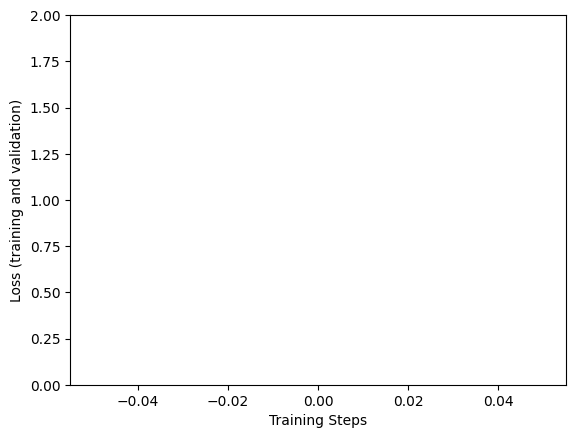

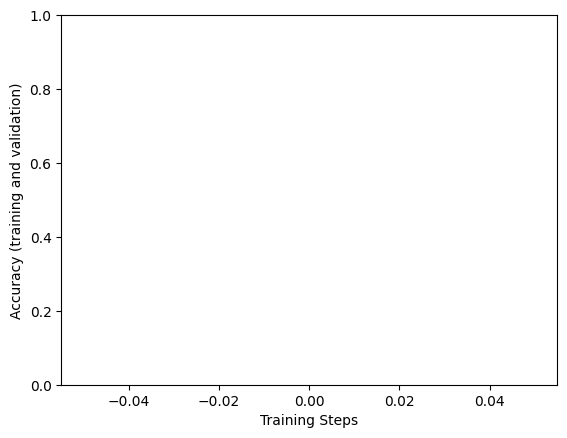

In [14]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

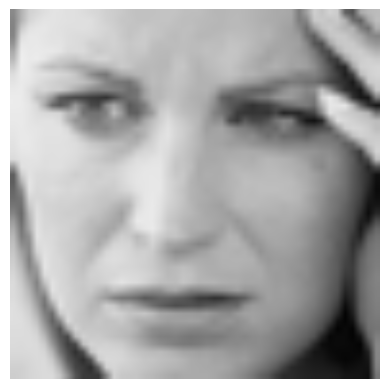

1/1 [==============================] - 5s 5s/step
True label: fearful
Predicted label: neutral


In [15]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [ ]:
# Find out if this method works for saving the model

model.save("content/drive/MyDrive/efficientnet_v1.h5")

In [19]:
def build_testset():
    return tf.keras.preprocessing.image_dataset_from_directory(
                        f"drive/MyDrive/archive/test",
                        label_mode="categorical",
                        color_mode="rgb",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42)

In [20]:
test_ds = build_testset()
test_size = test_ds.cardinality().numpy()
test_ds = test_ds.unbatch().batch(BATCH_SIZE)
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 7178 files belonging to 7 classes.


In [ ]:
predictions_test = model.predict(test_ds)

    158/Unknown - 165s 1s/step